In [18]:
import getpass
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from ai4mat.data.data import StorageResolver, read_trial

In [19]:
targets = ["formation_energy_per_site"]
results = []

if getpass.getuser() == "coder" and os.path.isdir("/home/coder/project/rolos_workflow_data"):
    PREDICTION_SOURCE = "ROLOS"
else:
    PREDICTION_SOURCE = "ASPIRE-1"

if PREDICTION_SOURCE == "ASPIRE-1":
    with open("../scripts/ASPIRE-1/MoS2_V2_E.txt", "rt") as definitions_file:
        for line in definitions_file:
            trial, target, n_repeats, _, experiment = line.strip().split()
            for i in range(1, int(n_repeats) + 1):
                these_results = read_trial(experiment, f"stability/{trial}/{i}", True, targets, True)
                if len(these_results) > 0:
                    these_results["trial_family"] = trial
                    these_results["trial_index"] = i
                    results.append(these_results)
elif PREDICTION_SOURCE == "ROLOS":
    experiment = "MoS2_V2"
    storage_root = "/home/coder/project/rolos_workflow_data/MoS2_V2/current/data"
    with open("../scripts/Rolos/MoS2_V2.txt", "rt") as definitions_file:
        for line in definitions_file:
            trial = line.rstrip()
            these_results = read_trial(experiment, trial, True, targets, True, storage_root)
            if len(these_results) > 0:
                these_results["trial_family"] = trial
                these_results["trial_index"] = 1
                results.append(these_results)

In [20]:
results_pd = pd.concat(results, axis=0)

In [21]:
folded_predictions = results_pd.loc[
    ("formation_energy_per_site", "combined"),
    ("trial_family", "trial_index", "predictions")].set_index(
        ["trial_family", "trial_index"]).squeeze()

/tmp/ipykernel_21153/2301786316.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  folded_predictions = results_pd.loc[


In [22]:
predictions_list = []
for (trail_family, trial_index), these_predictions in folded_predictions.items():
    prediction_frame = these_predictions.to_frame()
    prediction_frame["trial_family"] = trail_family
    prediction_frame["trial_index"] = trial_index
    prediction_frame.set_index(["trial_family", "trial_index", prediction_frame.index], inplace=True)
    predictions_list.append(prediction_frame.squeeze())

In [23]:
predictions_pd = pd.concat(predictions_list, axis=0)

In [24]:
structures = pd.read_pickle(StorageResolver()["processed"]/"low_density_defects/MoS2/data.pickle.gz").reindex(predictions_pd.index.get_level_values('_id').unique())

In [25]:
from operator import methodcaller
distances = structures.defect_representation.apply(methodcaller("get_distance", 0, 1))

In [26]:
true_energies = structures.formation_energy_per_site

In [27]:
distance_order = distances.argsort()

In [28]:
labels = {
    "schnet/25-11-2022_16-52-31/71debf15": "SchNet, tuned",
    "schnet/base": "SchNet, default",
    "catboost/29-11-2022_13-16-01/02e5eda9": "CatBoost, tuned",
    "catboost/base": "CatBoost, default",
    'gemnet/16-11-2022_20-05-04/b5723f85': "GemNet, tuned",
    "gemnet/base": "GemNet, default",
    "megnet_pytorch/25-11-2022_11-38-18/1baefba7": "MegNet (full), tuned",
    'megnet_pytorch/full/base': "MegNet (full), default",
    "megnet_pytorch/sparse/base": "MegNet (sparse), default",
    "megnet_pytorch/sparse/d6b7ce45_no_resample": "MegNet (sparse), tuned",
    "high_to_V2": "Tuned MegNet (sparse),\ntrained on high-density MoS$_2$ only"
}

In [29]:
predictions_pd.index.get_level_values("trial_family").unique()

Index(['schnet/25-11-2022_16-52-31/71debf15', 'schnet/base',
       'catboost/29-11-2022_13-16-01/02e5eda9', 'catboost/base',
       'gemnet/16-11-2022_20-05-04/b5723f85', 'gemnet/base',
       'megnet_pytorch/25-11-2022_11-38-18/1baefba7',
       'megnet_pytorch/full/base',
       'megnet_pytorch/sparse/d6b7ce45_no_resample',
       'megnet_pytorch/sparse/base'],
      dtype='object', name='trial_family')

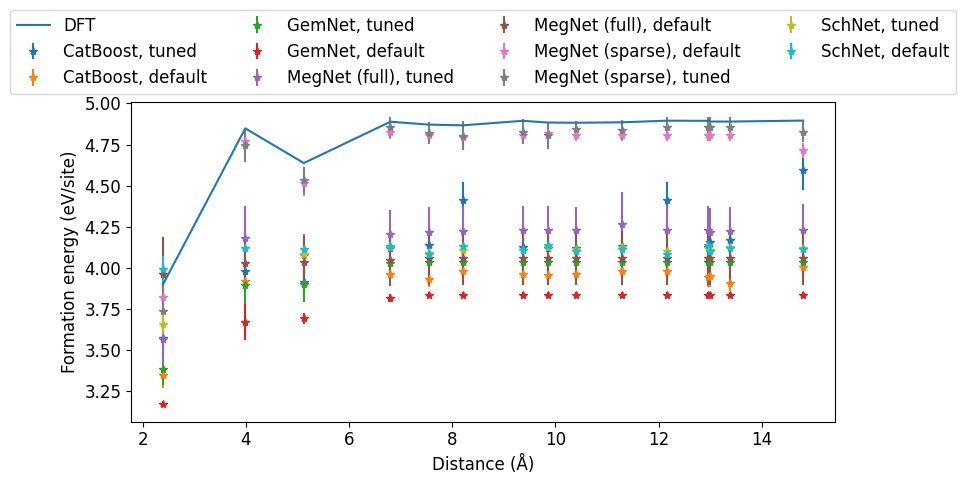

In [30]:
fig, ax = plt.subplots(figsize=(9.5, 5))
for trial_family, family_predictions in predictions_pd.groupby(level="trial_family"):
    prediction_mean = family_predictions.groupby(level="_id").mean()
    prediction_std = family_predictions.groupby(level="_id").std()
    if prediction_std.isna().any():
        ax.scatter(distances, prediction_mean, label=labels[trial_family])
    else:
        ax.errorbar(distances, prediction_mean, yerr=prediction_std, label=labels[trial_family], fmt="*")
ax.plot(distances[distance_order], true_energies[distance_order], label="DFT")
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncol=4)
ax.set_xlabel("Distance (Å)")
ax.set_ylabel("Formation energy (eV/site)")
plt.tight_layout()
fig.savefig("MoS2_V2.pdf")

In [31]:
font = {
        'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)


metadata = {
    "Title": "Energy as a function of ditance between defects in MoS2",
    "Keywords": "2D materials, machine learning, graph neural network, point defects"}

def plot_runs(runs, save_name):
        fig, axs = plt.subplot_mosaic([['upper left', 'upper right'],
                               ['middle left', 'middle right'],
                               ['lower', 'lower']],
                               figsize=(10, 10), constrained_layout=True, sharex=False, sharey=True)
        for i, (ax, (trial_family, name)) in enumerate(zip(axs.values(), paper_main.items())):
                family_predictions = predictions_pd.loc[trial_family]
                prediction_mean = family_predictions.groupby(level="_id").mean()
                prediction_std = family_predictions.groupby(level="_id").std()
                if prediction_std.isna().any():
                        predicted = ax.scatter(distances[distance_order], prediction_mean[distance_order], label="Predicted", color="navy", marker='o')
                else:
                        predicted = ax.errorbar(distances[distance_order],
                                                prediction_mean[distance_order],
                                                yerr=prediction_std[distance_order],
                                                color='navy', fmt='o-', mfc='white')
                dft = ax.plot(distances[distance_order], true_energies[distance_order], label="DFT", color="navy", marker='o', linestyle=':',mfc='white')
                ax.grid()
                ax.set_title(name)
                if i == 4:
                        predicted.set_label("Predicted")
                        dft[0].set_label("DFT")
                        ax.legend(loc="lower right")
        fig.supxlabel("Distance between the defects (Å)")
        fig.supylabel("Formation energy (eV/site)")
        fig.savefig(save_name, metadata=metadata)

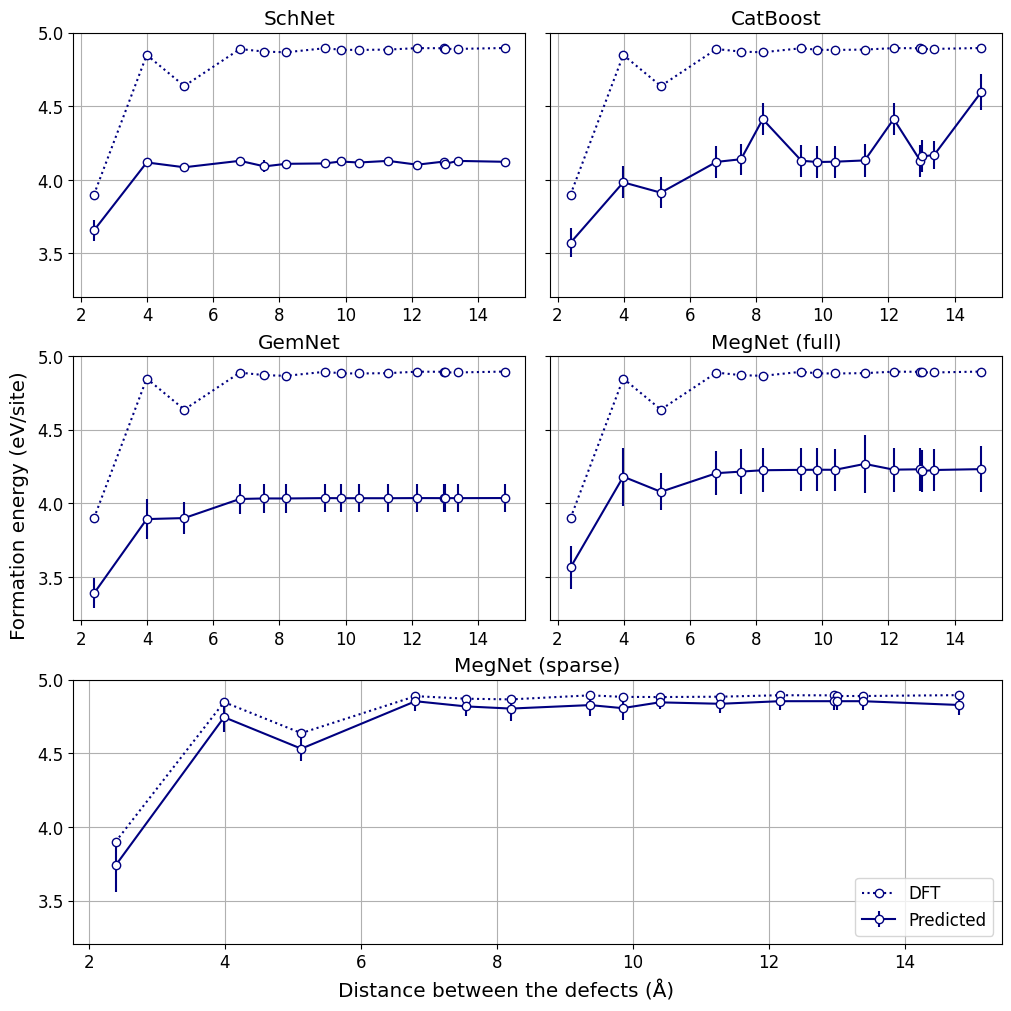

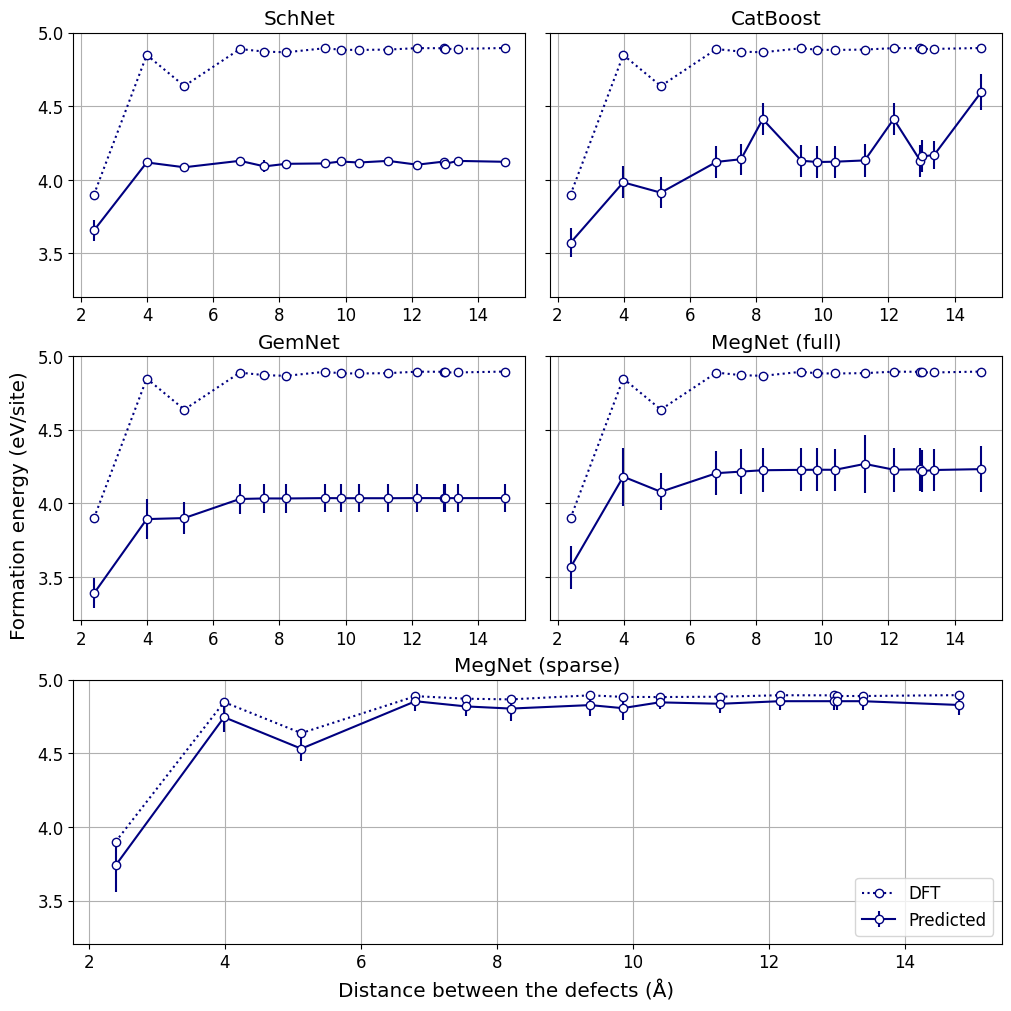

In [32]:
paper_main = {
    "schnet/25-11-2022_16-52-31/71debf15": "SchNet",
    "catboost/29-11-2022_13-16-01/02e5eda9": "CatBoost",
    'gemnet/16-11-2022_20-05-04/b5723f85': "GemNet",
    "megnet_pytorch/25-11-2022_11-38-18/1baefba7": "MegNet (full)",
    "megnet_pytorch/sparse/d6b7ce45_no_resample": "MegNet (sparse)",
}
paper_si = {
    "schnet/base": "SchNet",
    "catboost/base": "CatBoost",
    "gemnet/base": "GemNet",
    'megnet_pytorch/full/base': "MegNet (full)",
    "megnet_pytorch/sparse/base": "MegNet (sparse)",
}
plot_runs(paper_main, "MoS2_V2_tuned.pdf")
plot_runs(paper_main, "MoS2_V2_default.pdf")